In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pdb
import sys
import torch
from torch_geometric.data import Data
from torch_geometric.data import Dataset, DataLoader
from random import sample 
import os
import networkx as nx

sys.path.insert(0, 'C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/pycamotk')
print(sys.path)
from pyCaMOtk.create_mesh_hsphere import mesh_hsphere
from pyCaMOtk.create_mesh_hcube import mesh_hcube 
from pyCaMOtk.setup_linelptc_sclr_base_handcode import setup_linelptc_sclr_base_handcode
from pyCaMOtk.create_dbc_strct import create_dbc_strct
from pyCaMOtk.create_femsp_cg import create_femsp_cg
from pyCaMOtk.solve_fem import solve_fem
from pyCaMOtk.visualize_fem import visualize_fem
from pyCaMOtk.lfcnsp import LocalFunctionSpace

sys.path.insert(0, 'C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/source')
from FEM_ForwardModel import analyticalPossion, analyticalConeInterpolation, analyticalHeat2
from GCNNModel import e2vcg2connectivity,PossionNet
from TensorFEMCore import Double,solve_fem_GCNN,create_fem_resjac
import setup_prob_eqn_handcode

torch.manual_seed(0)


c:\Users\puppyCookie\anaconda3\envs\d2l\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/pycamotk', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\python38.zip', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\DLLs', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l', '', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib\\site-packages', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib\\site-packages\\win32', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib\\site-packages\\win32\\lib', 'c:\\Users\\puppyCookie\\anaconda3\\envs\\d2l\\lib\\site-packages\\Pythonwin']


- 邻接矩阵是取决于单元数量的，和多项式阶数关系不大，单元数量太大邻接矩阵会非常稠密，训练非常慢
- 这样的邻接矩阵建立的方式是否正确？


方形区域上的热方程（非齐次边界条件）
在方形区域 ($[0, 1] \times [0, 1]$) 上求解二维热方程： $u_t = \alpha \nabla^2 u $ 其中 ($\alpha$) 是热扩散系数。

真解
$$u(x, y, t) = e^{-2\pi^2 \alpha t} \sin(\pi x) \sin(\pi y) + x + y $$

边界条件
左边界：$u = y $
右边界：$ u = 1 + y $
上边界：$u = x + 1 $
下边界：$ u = x$
初始条件
$$ u(x, y, 0) = \sin(\pi x) \sin(\pi y) + x + y $$

In [2]:
"""
Hyper prameters
"""
tol=1.0e-16
maxit=800
delta_t=0.01



In [3]:
# GCNN model
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=PossionNet().to(device)
model=model.double()
# 加载模型
#statr_dict=torch.load('C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/demo0/model_1.pth')
#model.load_state_dict(statr_dict)

In [4]:
"""
Set up GCNN-FEM Possion problem
"""
# 算Δu
# 
nin=1 # Number of input variable
nvar=1 # Number of primanry variable
etype='hcube' # Mesh type
c=[0,0] # Domain center
r=1 # Radius
porder=2 # Polywwwnomial order for solution and geometry basis
nel=[2,2] # Number of element in x and y axis

lims = np.array([[0, 1], [0, 1]]) # Domain limits
msh=mesh_hcube(etype,lims,nel,porder).getmsh() # Create mesh object


xcg=msh.xcg # Extract node coordinates
#xcg[0]是x坐标，xcg[1]是y坐标
ndof=xcg.shape[1] #总节点数，也就是总自由度数
e2vcg=msh.e2vcg # Extract element connectivity 
connectivity=e2vcg2connectivity(msh.e2vcg,'ele') # Extract element connectivity
#输出一下e2vcg


[[[nan  0. nan  2.]
  [nan  2. nan  2.]]

 [[nan nan  0.  1.]
  [nan nan  3.  3.]]

 [[ 1. nan  3. nan]
  [ 0. nan  0. nan]]

 [[ 2.  3. nan nan]
  [ 1.  1. nan nan]]]
NnG: 25
NnE: 4
Nrow: 9


C:\Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/source\GCNNModel.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(torch.from_numpy(np.asarray(connectivity).T).to('cuda'),dtype=torch.long)


In [5]:
bnd2nbc=np.asarray([0]) # Define the boundary tag!
K=lambda x,el: np.asarray([[1],[0],[0],[1]])
"""
# The flux constant Flux=[du/dx, du/dy]^T=K dot [dphi/dx,dphi/dy]
where phi is the solution polynomial function
""" 
Qb=lambda x,n,bnd,el,fc: 0 # The primary variable value on the boundary

dbc_idx=[i for i in range(xcg.shape[1]) if np.sum(xcg[:,i]**2)>1-1e-12 or xcg[1,i]*xcg[0,i]==0] # The boundary node id
print(dbc_idx)
dbc_idx=np.asarray(dbc_idx) 
#用解析解来设置边界条件
dbc_val=analyticalHeat2(xcg,delta_t).flatten().reshape(ndof,1)[dbc_idx]

Ufem=analyticalHeat2(xcg,delta_t).flatten().reshape(ndof,1)

dbc=create_dbc_strct(xcg.shape[1]*nvar,dbc_idx,dbc_val) # Create the class of boundary condition


Src_new = torch.tensor([0.25], dtype=torch.double).to('cuda')
K_new=torch.tensor([[1],[0],[0],[1]]).to('cuda').double().reshape((4,))
parsfuncI=lambda x: torch.cat((K_new,Src_new),axis=0)
#看一下src_new的值
print(Ufem)

[0, 1, 2, 3, 4, 5, 9, 10, 14, 15, 18, 19, 20, 21, 22, 23, 24]
[[0.        ]
 [0.25      ]
 [0.5       ]
 [0.75      ]
 [1.        ]
 [0.25      ]
 [0.95300903]
 [1.39065151]
 [1.45300903]
 [1.25      ]
 [0.5       ]
 [1.39065151]
 [1.90601806]
 [1.89065151]
 [1.5       ]
 [0.75      ]
 [1.45300903]
 [1.89065151]
 [1.95300903]
 [1.75      ]
 [1.        ]
 [1.25      ]
 [1.5       ]
 [1.75      ]
 [2.        ]]


In [6]:
'''
# Define pameterized problem, in this case, the governing equation is changing and the loss
# function is changing
'''
S=[5] # Parametrize the source value in the pde -F_ij,j=S_i
LossF=[]
for i in S: 
	f=lambda x,el: i
	prob=setup_prob_eqn_handcode.setup_linelptc_sclr_base_handcode(2,K,f,Qb,bnd2nbc) # Set up the problem
	femsp=create_femsp_cg(prob,msh,porder,e2vcg,porder,e2vcg,dbc)
	fcn=lambda u_,u_n_1:create_fem_resjac('cg',u_n_1,u_,msh.transfdatacontiguous,
									femsp.elem,femsp.elem_data, 
                   				    femsp.ldof2gdof_eqn.ldof2gdof,
                  			        femsp.ldof2gdof_var.ldof2gdof,
									msh.e2e,femsp.spmat,dbc,[i for i in range(ndof) if i not in dbc_idx],parsfuncI,None)
	LossF.append(fcn)

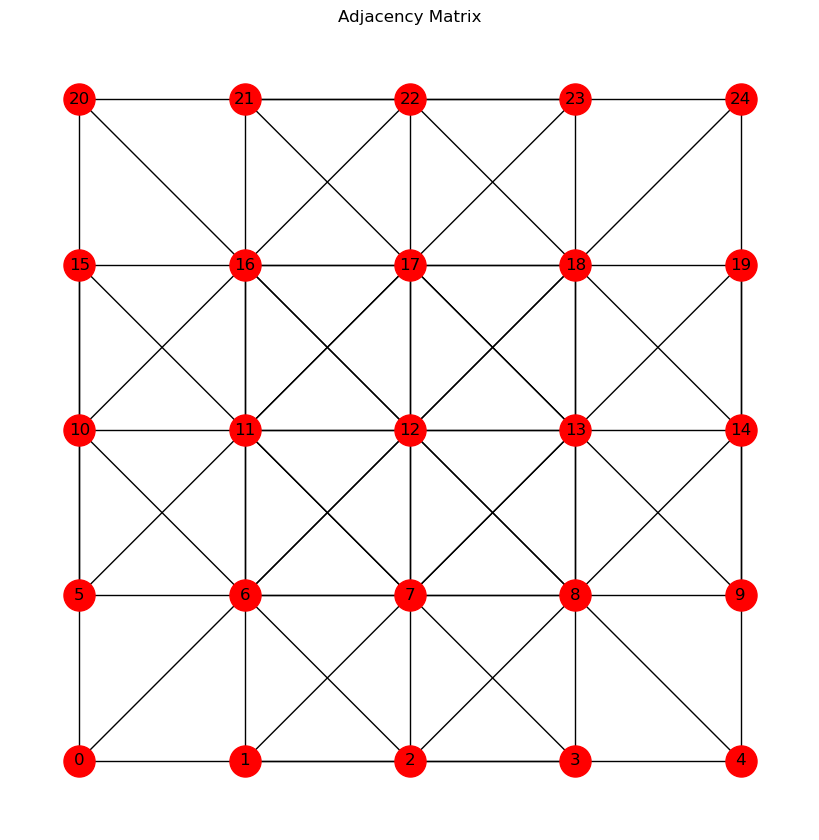

In [7]:
#绘制节点和邻接矩阵的示意图（connectivity是邻接矩阵）
edges = connectivity.cpu().numpy().T.tolist()
G = nx.Graph()
G.add_edges_from(edges)

pos = {i: (xcg[0, i], xcg[1, i]) for i in range(xcg.shape[1])}
plt.figure(figsize=(8, 8))
nx.draw(G, pos, with_labels=True, node_color='r', node_size=500, font_size=12)
plt.title('Adjacency Matrix')
plt.show()

In [8]:
def create_dataloader(xcg, solution,t):
	Graph=[]
	Ue=Double(analyticalHeat2(xcg,t).flatten().reshape(ndof,1))
	fcn_id=Double(np.asarray([0]))
	Ue_aug=torch.cat((fcn_id,Ue),axis=0)
	Uin=Double(xcg.T)
	#给Uin加上一列,就是把上一次得到的solution加上去
	Un_1=Double(solution)
	#Un_1 =torch.zeros_like(Un_1)
	#整理形状
	Uin=torch.cat((Uin,Un_1),axis=1)
	#for i in range(Uin.shape[0]):
	#这里改变一下输入的数据
	graph=Data(x=Un_1,y=Ue_aug,edge_index=connectivity)
	Graph.append(graph)

	DataList=[[Graph[i]] for i in range(len(S))]
	TrainDataloader=DataLoader(DataList,batch_size=1)
	return TrainDataloader, Graph, Un_1


C:\Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/source\TensorFEMCore.py:334: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  return torch.tensor([A]).reshape([1,1]).double().to('cuda')
c:\Users\puppyCookie\anaconda3\envs\d2l\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
C:\Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/source\TensorFEMCore.py:323: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse 

epoch =  0


C:\Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/source\setup_prob_eqn_handcode.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k_ml=torch.tensor(k).double().to('cuda')


Re_vol =  tensor([[0.0007],
        [0.0067],
        [0.0027],
        [0.0067],
        [0.1096],
        [0.0416],
        [0.0027],
        [0.0416],
        [0.0150]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SubBackward0>)
Re_vol =  tensor([[0.0029],
        [0.0180],
        [0.0062],
        [0.0414],
        [0.1767],
        [0.0276],
        [0.0144],
        [0.0577],
        [0.0074]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SubBackward0>)
Re_vol =  tensor([[0.0029],
        [0.0414],
        [0.0144],
        [0.0180],
        [0.1767],
        [0.0577],
        [0.0062],
        [0.0276],
        [0.0074]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SubBackward0>)
Re_vol =  tensor([[0.0174],
        [0.0679],
        [0.0111],
        [0.0679],
        [0.1882],
        [0.0493],
        [0.0111],
        [0.0493],
        [0.0152]], device='cuda:0', dtype=torch.float64,
       grad_fn=<SubBackward0>)
Max Rf =========================

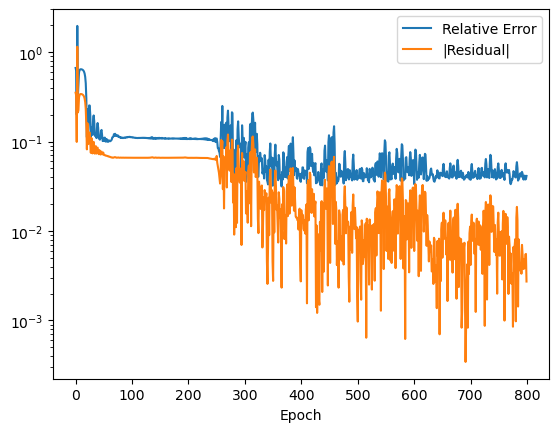

wallclock time of all epochs =  356.5644633769989
Min Error= 0.03141356871186774
Mean Error Last 10 iterations= 0.04054825706595898
Var  Error Last 10 iterations= 6.836363350485096e-06


In [9]:
#循环训练，上一次训练好的模型的解作为下一次训练的输入
#训练次数：30
Un_list = []
t = 0
solution = analyticalHeat2(xcg,t)
Un_list.append(solution)
for i in range(1):
    #训练模型
    # Training Data
    #构造这次训练的dataloader、graph和Un_1
    t = (i+1)*delta_t
    solution = solution.reshape(ndof, 1)
    TrainDataloader, Graph, Un_1 = create_dataloader(xcg, solution, t)

    [model,info]=solve_fem_GCNN(Un_1,TrainDataloader,LossF,model,tol,maxit)
    print('Min Error=',info['Er'].min())
    print('Mean Error Last 10 iterations=',np.mean(info['Er'][-10:]))
    print('Var  Error Last 10 iterations=',np.var(info['Er'][-10:]))
    
    dbc_val=analyticalHeat2(xcg,t).flatten().reshape(ndof,1)[dbc_idx]
    dbc=create_dbc_strct(xcg.shape[1]*nvar,dbc_idx,dbc_val) # Create the class of boundary condition
    
    solution=model(Graph[0].to('cuda'))
    solution[dbc.dbc_idx]=Double(dbc.dbc_val.reshape([len(dbc.dbc_val),1]))

    solution=solution.detach().cpu().numpy()
    #边界赋值

   
    Un_list.append(solution)
    #保存此次模型，名字用序号命名
    torch.save(model.state_dict(), 'C:/Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/demo0/model_'+str(i)+'.pth')
    

In [10]:
#计算l2误差、l无穷误差、l1误差
l2_error = []
l1_error = []
l_inf_error = []
for i in range(1):
    t = (i+1)*delta_t
    solution = Un_list[i+1]
    analytical_solution = analyticalHeat2(xcg,t).flatten().reshape(ndof,1)
    l2_error.append(np.sqrt(np.sum((solution-analytical_solution)**2)))
    l1_error.append(np.sum(np.abs(solution-analytical_solution)))
    l_inf_error.append(np.max(np.abs(solution-analytical_solution)))
    print('l2_error:', l2_error[-1])
    print('l1_error:', l1_error[-1])
    print('l_inf_error:', l_inf_error[-1])
    print('===============================')

l2_error: 0.2754464100393786
l1_error: 0.5905893642836366
l_inf_error: 0.1678162259443563


In [11]:
solution=model(Graph[0].to('cuda'))
solution[dbc.dbc_idx]=Double(dbc.dbc_val.reshape([len(dbc.dbc_val),1]))
solution=solution.detach().cpu().numpy()

zeval: [[-1.  -0.5  0.   0.5  1.  -1.  -0.5  0.   0.5  1.  -1.  -0.5  0.   0.5
   1.  -1.  -0.5  0.   0.5  1.  -1.  -0.5  0.   0.5  1. ]
 [-1.  -1.  -1.  -1.  -1.  -0.5 -0.5 -0.5 -0.5 -0.5  0.   0.   0.   0.
   0.   0.5  0.5  0.5  0.5  0.5  1.   1.   1.   1.   1. ]]
评估点的数量  25
zeval: [[-1.  -0.5  0.   0.5  1.  -1.  -0.5  0.   0.5  1.  -1.  -0.5  0.   0.5
   1.  -1.  -0.5  0.   0.5  1.  -1.  -0.5  0.   0.5  1. ]
 [-1.  -1.  -1.  -1.  -1.  -0.5 -0.5 -0.5 -0.5 -0.5  0.   0.   0.   0.
   0.   0.5  0.5  0.5  0.5  0.5  1.   1.   1.   1.   1. ]]
评估点的数量  25


C:\Users/puppyCookie/Downloads/graphGalerkin-main/graphGalerkin-main/pycamotk\pyCaMOtk\visualize_fem.py:144: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\puppyCookie\AppData\Local\Temp\ipykernel_19484\2750466296.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()              # 自动调整子图间距
C:\Users\puppyCookie\AppData\Local\Temp\ipykernel_19484\2750466296.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()              # 自动调整子图间距


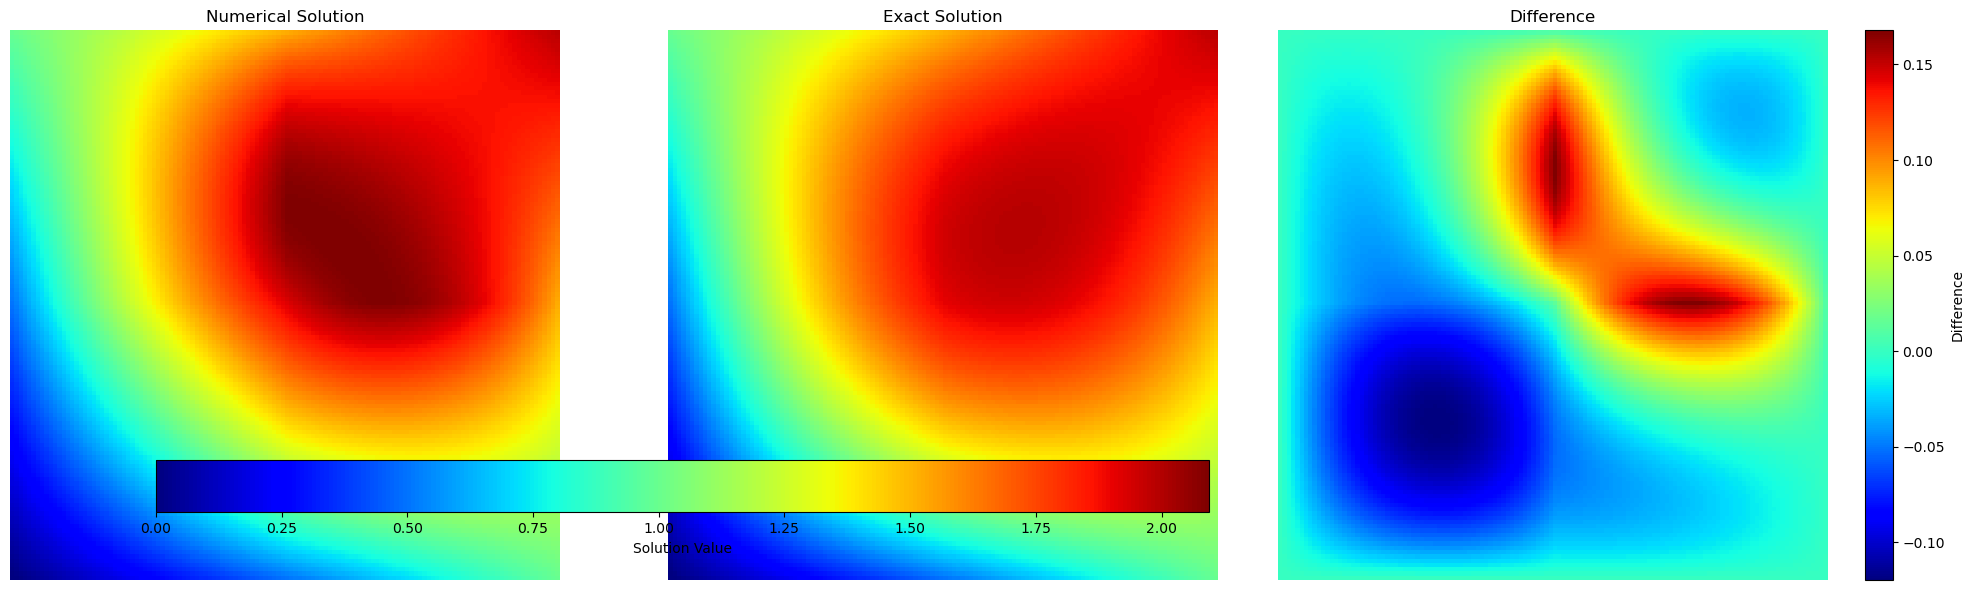

In [12]:
solution=Un_list[1]
Ufem=analyticalHeat2(xcg,0.01).flatten().reshape(ndof,1)
#检查真解和数值解的形状是否一致，如果不一致就统一成solution的形状
if Ufem.shape!=solution.shape:
    Ufem=Ufem.reshape(solution.shape)
fig, axes, cbar = visualize_fem(
    msh, 
    udg=solution[e2vcg], 
    ufem=Ufem[e2vcg],        # 传入真解
    opts={"plot_elem": True, "nref": 6}, 
    which_bnd=[]
)

# 分别设置三个子图的标题
titles = ['Numerical Solution', 'Exact Solution', 'Difference']
for ax, title in zip(axes, titles):
    ax.tick_params(axis='both', which='both', 
                   bottom=False, left=False, 
                   top=False, labelbottom=False, labelleft=False)
    ax.set_title(title)
    ax.axis('off')

plt.margins(0,0)
plt.tight_layout()              # 自动调整子图间距
plt.show()